# Исследование поведения пользователей в мобильном приложении для продажи продуктов питания.
____

### В данном исследовании изучается путь пользователей до покупки, а также исследуются результаты проведенного А/А/В теста.

### Исследование проводится на основе собранных приложением данных о действиях пользователей.
____

### Исследование разделено на несколько частей.

#### [Часть 1. Подготовка к исследованию и изучение общей информации:](#1)

- [1. Импорт библиотек.](#1.1)
- [2. Получение и изучение общей информации о данных.](#1.2)
- [3. Функции для построения графиков.](#1.3)

#### [Часть 2. Подготовка данных:](#2)

- [1. Переименование столбцов и приведение данных к нужным типам.](#2.1)
- [2. Обработка дубликатов.](#2.2)
- [3. Нахождение и исправление ошибок.](#2.3)
- [4. Добавление необходимых данных.](#2.4)

#### [Часть 3. Изучение и обработка данных:](#3)

- [1. Изучение количества качественных данных.](#3.1)
- [2. Изучение периода времени, за который есть данные.](#3.2)

#### [Часть 4. Построение и изучение воронки событий.](#4)

- [1. Подготовка к построению воронки событий.](#4.1)
- [2. Построение и изучение воронки событий.](#4.2)

#### [Часть 5. Исследование результатов А/А/В теста.](#5)

- [1. Подготовка к исследованию теста.](#5.1)
- [2. Сравнение двух контрольных групп.](#5.2)
- [3. Сравнение группы с измененным шрифтом с контрольными.](#5.3)

#### [Часть 6. Вывод.](#6)

## Часть 1. Подготовка к исследованию и изучение общей информации. <a id='1'></a>

### 1. Импорт библиотек <a id='1.1'></a>

In [33]:
import pandas as pd
import seaborn as sns
import numpy as np
import math as mth
import matplotlib.pyplot as plt
import re
from scipy import stats as st
pd.set_option('display.max_columns', 100)

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

import plotly.express as px

### 2. Получение и изучение общей информации о данных <a id='1.2'></a>

In [34]:
logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
logs.info()
display(logs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Проверим таблицу на наличие дубликатов.

In [35]:
logs.duplicated().sum()

413

### Вывод:
1. Надо заменить названия столбцов.
2. Надо перевести время в тип данных `datetime`.
3. Надо разобраться с дубликатами.

### 3. Функции для построения графиков. <a id='1.3'></a>

Гистограмма.

In [36]:
def do_hist(x, bins, title, xlabel, ylabel, density=False):
    plt.hist(x, bins=bins, density=density)
    plt.title(title, size='xx-large')
    plt.xlabel(xlabel, size='x-large')
    plt.ylabel(ylabel, size='x-large')

Barplot.

In [37]:
def do_barplot(x, y, title, xlabel, ylabel, hue=None):
    sns.barplot(x, y, hue=hue)
    plt.title(title, size='xx-large')
    plt.xlabel(xlabel, size='x-large')
    plt.ylabel(ylabel, size='x-large')

## Часть 2. Подготовка данных. <a id='2'></a>

### 1. Переименование столбцов и приведение данных к нужным типам. <a id='2.1'></a>

Переименуем столбцы.

In [38]:
logs.columns = ['event_name', 'device_id_hash', 'event_time', 'exp_id']
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
event_name        244126 non-null object
device_id_hash    244126 non-null int64
event_time        244126 non-null int64
exp_id            244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Приведем дату в тип `datetime`.

In [39]:
logs['event_time'] = pd.to_datetime(logs['event_time'], unit='s')
display(logs.head())

,event_name,device_id_hash,event_time,exp_id
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


### 2. Обработка дубликатов. <a id='2.2'></a>

Поскольку в каждой строчке есть время и id пользователя, дубликаты можно смело удалять.

In [40]:
logs = logs.drop_duplicates().reset_index(drop=True)
logs.duplicated().sum()

0

### 3. Нахождение и исправление ошибок. <a id='2.3'></a>

Проверим названия событий.

In [41]:
print(logs['event_name'].unique())

['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


С ними все хорошо.

Проверим нет ли странных дат.

In [42]:
logs['event_time'].describe()

count                  243713
unique                 176654
top       2019-08-01 14:40:35
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: event_time, dtype: object

С ними все хорошо.

Проверим: нет ли неправильных id групп.

In [43]:
print(logs['exp_id'].unique())

[246 248 247]


Проверим: не попал ли один и тот же пользователь в разные группы.

In [44]:
vis1 = set(logs[logs['exp_id']==246]['device_id_hash'])
vis2 = set(logs[logs['exp_id']==247]['device_id_hash'])
vis3 = set(logs[logs['exp_id']==248]['device_id_hash'])
vis = vis1.intersection(vis2) | vis2.intersection(vis3) | vis1.intersection(vis3)
print(len(vis))

0


### 4. Добавление необходимых данных. <a id='2.4'></a>

Добавим столбец с датой

In [45]:
logs['date'] = logs['event_time'].dt.date
display(logs.head())

,event_name,device_id_hash,event_time,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


## Часть 3. Изучение и обработка данных. <a id='3'></a>

### 1. Изучение количества качественных данных. <a id='3.1'></a>

In [46]:
unique_logs_number = len(logs['event_name'].unique())
logs_number = len(logs)
users_number = len(logs['device_id_hash'].unique())
logs_by_user = logs_number / users_number
print('Количество событий: {}.'.format(logs_number), 'Из них различных видов событий: {}.'.format(unique_logs_number))
print('Количество различных пользователей: {}.'.format(users_number), 
      'В среднем на одного пользователя приходится: {:.2f} событий.'.format(logs_by_user))

Количество событий: 243713. Из них различных видов событий: 5.
Количество различных пользователей: 7551. В среднем на одного пользователя приходится: 32.28 событий.


### 2. Изучение периода времени, за который есть данные. <a id='3.2'></a>

In [47]:
logs['event_time'].describe()

count                  243713
unique                 176654
top       2019-08-01 14:40:35
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: event_time, dtype: object

Мы распологаем данными с 25 июня по 7 августа 2019 года. 

Посмотрим как наши данные распределены по времени

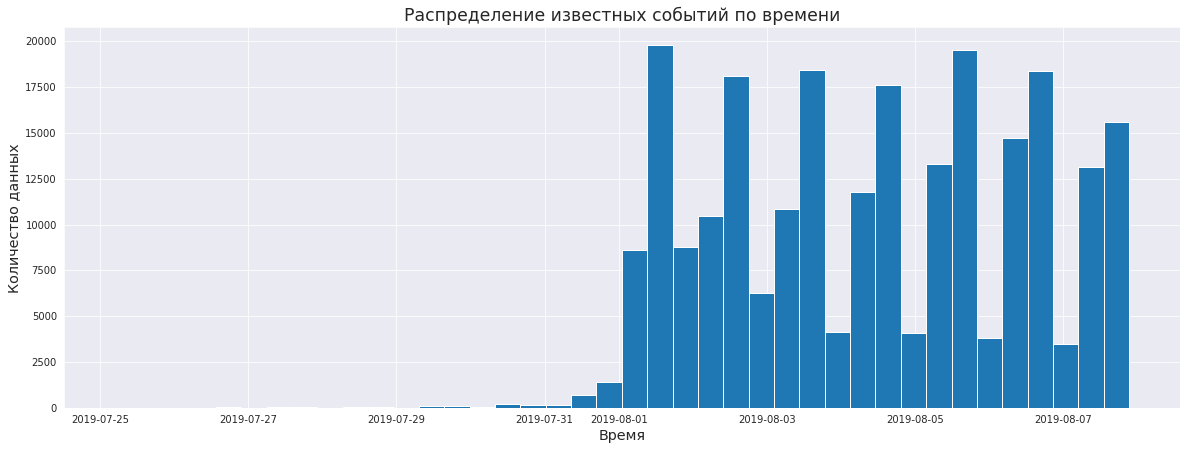

In [48]:
plt.rcParams['figure.figsize']=(20, 7)
do_hist(x=logs['event_time'], bins=40, xlabel='Время', ylabel='Количество данных', title='Распределение известных событий по времени')

На самом деле у нас есть полные данные только 1 августа 2019 года по 8 августа 2019 года.

Более старые данные удалим, чтобы они не загрязняли результаты. Проверим, сколько событий и посетителей мы из-за этого потеряли.

In [49]:
logs = logs[logs['event_time'] >= '2019-08-01']
good_logs_number = len(logs)
good_users_number = len(logs['device_id_hash'].unique())
print('Мы потеряли: {:.1%} событий и {:.1%} пользователей.'.format(1 - good_logs_number/logs_number, 1 - good_users_number/users_number))

Мы потеряли: 1.2% событий и 0.2% пользователей.


## Часть 4. Построение и изучение воронки событий. <a id='4'></a>

### 1. Подготовка к построению воронки событий. <a id='4.1'></a>

Посмотрим как часто встречаются различные виды событий.

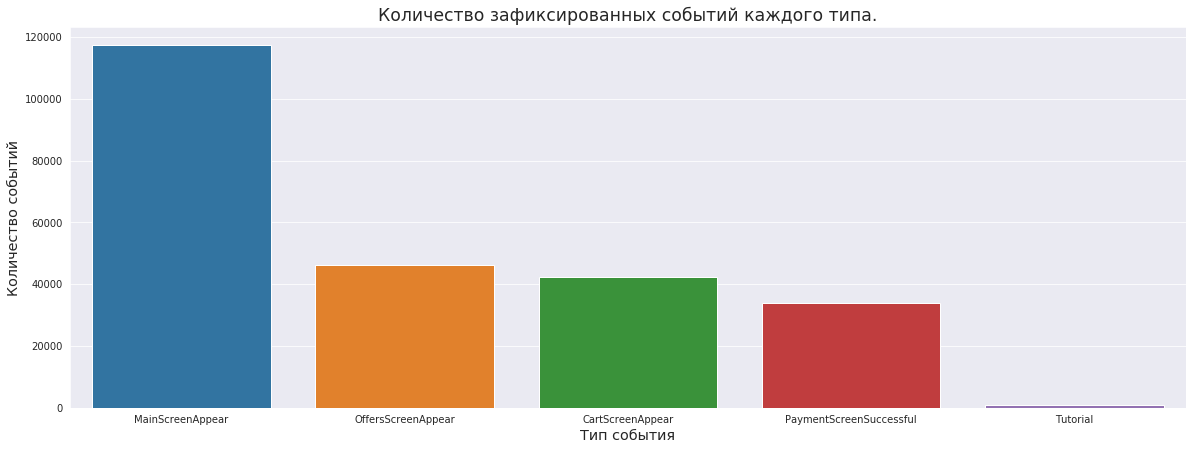

In [50]:
logs_frequency = logs.groupby('event_name').agg({'exp_id': 'count', 'device_id_hash': pd.Series.nunique}).sort_values(by='exp_id', ascending=False)
logs_frequency.columns = ['n_events', 'n_users']
do_barplot(x=logs_frequency.index, y=logs_frequency['n_events'], 
           title='Количество зафиксированных событий каждого типа.', 
           xlabel='Тип события', ylabel='Количество событий')

Посмотрим какая пользователей совершают каждый из типов событий.

,n_events,n_users,users_proportion
event_name,,,
MainScreenAppear,117328,7419,0.984736
OffersScreenAppear,46333,4593,0.609636
CartScreenAppear,42303,3734,0.495620
PaymentScreenSuccessful,33918,3539,0.469737
Tutorial,1005,840,0.111495


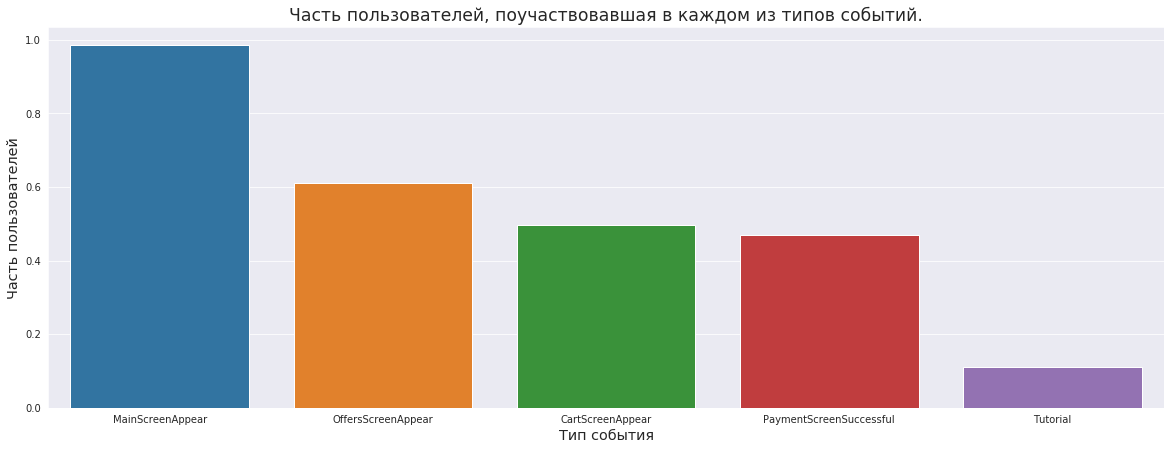

In [51]:
logs_frequency['users_proportion'] = logs_frequency['n_users'] / good_users_number
logs_frequency = logs_frequency.sort_values(by='users_proportion', ascending=False)
do_barplot(x=logs_frequency.index, y=logs_frequency['users_proportion'], 
           title='Часть пользователей, поучаствовавшая в каждом из типов событий.', 
           xlabel='Тип события', ylabel='Часть пользователей')
display(logs_frequency)

Вывод:
1. И по частоте событий и по доле посетителей, участвовавших в событии различные типы событий сортируются одинаково: чаще всего пользователи видят главный экран, значительно реже экран товара, еще реже корзину, еще реже экран, подтверждающий успешность покупки и реже всего - обучение.
2. При использовании приложения пользователи чаще всего начинают с главного экрана, потом экран товара, потом экран корзины и потом экран, подтверждающий успешность покупки. Обучение многие игнорируют, поэтому его, при построении воронки, учитывать не будем.

### 2. Построение и изучение воронки событий. <a id='4.2'></a>

Для пользователей посчитаем время первого срабатывания каждого события.

In [52]:
user_first_event_time = logs.pivot_table(index='device_id_hash', columns='event_name', values='event_time', aggfunc='min')
display(user_first_event_time.head())

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial
device_id_hash,,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58,NaT
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40,NaT
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45,NaT


Построим воронку.

In [53]:
funnel = []
funnel.append(user_first_event_time[~user_first_event_time['MainScreenAppear'].isna()].shape[0])
funnel.append(user_first_event_time[~user_first_event_time['OffersScreenAppear'].isna()].shape[0])
funnel.append(user_first_event_time[~user_first_event_time['CartScreenAppear'].isna()].shape[0])
funnel.append(user_first_event_time[~user_first_event_time['PaymentScreenSuccessful'].isna()].shape[0])

names_funnel = ['посещение главного экрана', 'посещение экрана товара', 'посещение корзины', 'экран успешной оплаты']

funnel_data = pd.DataFrame(names_funnel, columns=['Шаг'])
funnel_data['Количество пользователей'] = funnel
funnel_data['Доля пользователей от общего числа'] = funnel_data['Количество пользователей'] / good_users_number

portion_of_prev_stage = [1]
portion_of_prev_stage.extend(list(funnel_data['Количество пользователей'].drop(index=0)) / (funnel_data['Количество пользователей'].drop(index=3)))
funnel_data['Доля пользователей от прошлого шага'] = portion_of_prev_stage
display(funnel_data)

,Шаг,Количество пользователей,Доля пользователей от общего числа,Доля пользователей от прошлого шага
0,посещение главного экрана,7419,0.984736,1.000000
1,посещение экрана товара,4593,0.609636,0.619086
2,посещение корзины,3734,0.495620,0.812976
3,экран успешной оплаты,3539,0.469737,0.947777


Вывод:
1. Больше всего пользователей мы теряем после посещения главного экрана: 38%.
2. Почти половина пользователей (47%) совершает покупку!

## Часть 5. Исследование результатов А/А/В теста. <a id='5'></a>

### 1. Подготовка к исследованию теста. <a id='5.1'></a>

Выделим таблицы с каждой из групп.

In [54]:
group_246 = logs[logs['exp_id'] == 246]
group_247 = logs[logs['exp_id'] == 247]
group_248 = logs[logs['exp_id'] == 248]

Для каждой группыс

Посчитаем количество людей в каждой группе.

In [55]:
n_users_in_246 = len(group_246['device_id_hash'].unique())
n_users_in_247 = len(group_247['device_id_hash'].unique())
n_users_in_248 = len(group_248['device_id_hash'].unique())

print('Количество людей в 246 группе: {}.'.format(n_users_in_246))
print('Количество людей в 247 группе: {}.'.format(n_users_in_247))
print('Количество людей в 248 группе: {}.'.format(n_users_in_248))

Количество людей в 246 группе: 2484.
Количество людей в 247 группе: 2513.
Количество людей в 248 группе: 2537.


Для каждой группы создадим таблицу со строчками соответствующими событиям, в первом столбце количество людей, поучаствовавших в событии, а во втором - количество людей в группе.

In [56]:
def build_for_test(group, n_users):
    result = group.pivot_table(index='event_name', columns='exp_id', values='device_id_hash', aggfunc=pd.Series.nunique)
    result.columns = ['successed']
    result['trials'] = n_users
    result['portion'] = result['successed'] / result['trials']
    return result

for_test_246 = build_for_test(group_246, n_users_in_246)
for_test_247 = build_for_test(group_247, n_users_in_247)
for_test_248 = build_for_test(group_248, n_users_in_248)

display(for_test_246)
display(for_test_247)
display(for_test_248)

,successed,trials,portion
event_name,,,
CartScreenAppear,1266,2484,0.509662
MainScreenAppear,2450,2484,0.986312
OffersScreenAppear,1542,2484,0.620773
PaymentScreenSuccessful,1200,2484,0.483092
Tutorial,278,2484,0.111916


,successed,trials,portion
event_name,,,
CartScreenAppear,1238,2513,0.492638
MainScreenAppear,2476,2513,0.985277
OffersScreenAppear,1520,2513,0.604855
PaymentScreenSuccessful,1158,2513,0.460804
Tutorial,283,2513,0.112614


,successed,trials,portion
event_name,,,
CartScreenAppear,1230,2537,0.484825
MainScreenAppear,2493,2537,0.982657
OffersScreenAppear,1531,2537,0.603469
PaymentScreenSuccessful,1181,2537,0.465510
Tutorial,279,2537,0.109972


Уровень значимости сделаем 0.05, но из-за того, что у нас будет 4 проверки (246 группа с 247, 246 с 248, 247 с 248, объединенная 246 и 247 с 248)  сделаем поправку Бонферрони.

In [57]:
alpha = .05 / 4

Создадим словарь, который будет переводить названия событий с английского на русский.

In [58]:
events_dict = {
    'MainScreenAppear': '"Появление главного экрана"',
    'CartScreenAppear': '"Появление корзины"',
    'OffersScreenAppear': '"Появление экрана товара"',
    'PaymentScreenSuccessful': '"Появление экрана, подтверждающего успешность покупки"',
    'Tutorial': '"Обучение"'
}

Создадим функцию для сравнения 2 групп.

In [59]:
events = list(logs_frequency.index)

def comp_groups(data_1, data_2, group_1, group_2):
    p_combined = (data_1['successed'] + data_2['successed']) / (data_1['trials'] + data_2['trials'])
    difference = data_1['portion'] - data_2['portion']
    distr = st.norm(0, 1)
    for i in events:
        print('Нулевая гипотеза: доля пользователей, совершивших событие',
              events_dict[i],
              'в группе {} равна доле пользователей, совершивших это событие в группе {}.'
              .format(group_1, group_2)
             )
        print()
        print('Альтернативная гипотеза: доля пользователей, совершивших событие',
              events_dict[i],
              'в группе {} не равна доле пользователей, совершивших это событие в группе {}.'
              .format(group_1, group_2))
        print()
        z_value = difference[i] / mth.sqrt(p_combined[i] * (1 - p_combined[i]) * (1/data_1.loc[i, 'trials'] + 1/data_2.loc[i, 'trials']))
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('p-значение: ', p_value)
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница.')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.')
        print()
        print()
        print()

### 2. Сравнение двух контрольных групп. <a id='5.2'></a>

In [60]:
comp_groups(for_test_246, for_test_247, '246', '247')

Нулевая гипотеза: доля пользователей, совершивших событие "Появление главного экрана" в группе 246 равна доле пользователей, совершивших это событие в группе 247.

Альтернативная гипотеза: доля пользователей, совершивших событие "Появление главного экрана" в группе 246 не равна доле пользователей, совершивших это событие в группе 247.

p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.



Нулевая гипотеза: доля пользователей, совершивших событие "Появление экрана товара" в группе 246 равна доле пользователей, совершивших это событие в группе 247.

Альтернативная гипотеза: доля пользователей, совершивших событие "Появление экрана товара" в группе 246 не равна доле пользователей, совершивших это событие в группе 247.

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.



Нулевая гипотеза: доля пользователей, совершивших событие "Появление корзины" в группе 246 равна дол

### Вывод:
Для всех событий разница доли пользователей, совершивших событие в группе 246 и доли пользователей, совершивших событие в группе 247 статистически не значима. Это означает, что разницы между группами 246 и 247, с точки зрения статистики, нет. Поэтому, можно считать, что разбиение на группы работает корректно.

### 3. Сравнение группы с измененным шрифтом с контрольными. <a id='5.3'></a>

Сравнение группы 248 и 246.

In [61]:
comp_groups(for_test_246, for_test_248, '246', '248')

Нулевая гипотеза: доля пользователей, совершивших событие "Появление главного экрана" в группе 246 равна доле пользователей, совершивших это событие в группе 248.

Альтернативная гипотеза: доля пользователей, совершивших событие "Появление главного экрана" в группе 246 не равна доле пользователей, совершивших это событие в группе 248.

p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.



Нулевая гипотеза: доля пользователей, совершивших событие "Появление экрана товара" в группе 246 равна доле пользователей, совершивших это событие в группе 248.

Альтернативная гипотеза: доля пользователей, совершивших событие "Появление экрана товара" в группе 246 не равна доле пользователей, совершивших это событие в группе 248.

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.



Нулевая гипотеза: доля пользователей, совершивших событие "Появление корзины" в группе 246 равна до

Сравнение группы 248 и 247.

In [62]:
comp_groups(for_test_247, for_test_248, '247', '248')

Нулевая гипотеза: доля пользователей, совершивших событие "Появление главного экрана" в группе 247 равна доле пользователей, совершивших это событие в группе 248.

Альтернативная гипотеза: доля пользователей, совершивших событие "Появление главного экрана" в группе 247 не равна доле пользователей, совершивших это событие в группе 248.

p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.



Нулевая гипотеза: доля пользователей, совершивших событие "Появление экрана товара" в группе 247 равна доле пользователей, совершивших это событие в группе 248.

Альтернативная гипотеза: доля пользователей, совершивших событие "Появление экрана товара" в группе 247 не равна доле пользователей, совершивших это событие в группе 248.

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.



Нулевая гипотеза: доля пользователей, совершивших событие "Появление корзины" в группе 247 равна дол

Сравнение группы 248 и объединения групп 246 и 247.

In [63]:
group_A_union = for_test_246 + for_test_247
group_A_union['portion'] = group_A_union['successed'] / group_A_union['trials']
comp_groups(group_A_union, for_test_248, '"объединение 246 и 247"', '248')

Нулевая гипотеза: доля пользователей, совершивших событие "Появление главного экрана" в группе "объединение 246 и 247" равна доле пользователей, совершивших это событие в группе 248.

Альтернативная гипотеза: доля пользователей, совершивших событие "Появление главного экрана" в группе "объединение 246 и 247" не равна доле пользователей, совершивших это событие в группе 248.

p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.



Нулевая гипотеза: доля пользователей, совершивших событие "Появление экрана товара" в группе "объединение 246 и 247" равна доле пользователей, совершивших это событие в группе 248.

Альтернативная гипотеза: доля пользователей, совершивших событие "Появление экрана товара" в группе "объединение 246 и 247" не равна доле пользователей, совершивших это событие в группе 248.

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.



Нулевая гипотеза: 

### Вывод:
Разница между группой с измененным шрифтом и контрольными статистически не значима.

## Часть 6. Вывод. <a id='6'></a>

1. Проделанная работа:
    1. Мы изучили общую информацию о данных.
    2. Мы переименовали столбцы, привели данные к нужным типам, обработали дубликаты и добавили столбец с датой.
    3. Мы изучили количество различных качественных данных, имеющихся у нас.
    4. Мы определили период времени, за который у нас есть полный набор данных.
    5. Мы построили и изучили воронку событий.
    6. Мы исследовали результаты проведенного А/А/В теста.
        

2. В ходе исследования я пришел к следующим выводам:
    1. Изучение событий:
        1. И по частоте событий и по доле посетителей, участвовавших в событии, различные типы событий сортируются одинаково: чаще всего пользователи видят главный экран, значительно реже экран товара, еще реже корзину, еще реже экран, подтверждающий успешность покупки и реже всего - обучение.
        2. При использовании приложения пользователи чаще всего начинают с главного экрана, потом экран товара, потом экран корзины и потом экран, подтверждающий успешность покупки. Обучение многие игнорируют.
        1. Больше всего пользователей мы теряем после посещения главного экрана: 38%.
        2. Почти половина пользователей (47%) совершает покупку!
    2. Результаты А/А/В теста:
        1. Для всех событий разница доли пользователей, совершивших событие в группе 246 и доли пользователей, совершивших событие в группе 247 статистически не значима. Это означает, что разницы между группами 246 и 247, с точки зрения статистики, нет. Поэтому, можно считать, что разбиение на группы работает корректно. 
        2. Разница между группой с измененным шрифтом и контрольными статистически не значима.